In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import sys
import json
import time
import h5py as h5

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf
from scalebars import *
import deconv

# import balance_configs as configs
import sac_mode_configs as configs
import experiments as exps
import analysis as ana
sys.path.append('../imaging-utils')
from image_arrays import map_axis

In [2]:
# %matplotlib notebook
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

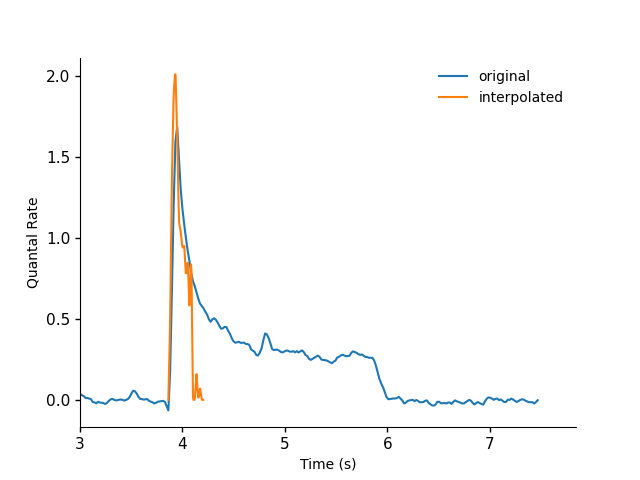

In [3]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
# target_rate_dt = 0.001  # 0.0001
target_rate_dt = 0.005  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

trans_rise = find_rise_bsln(bp_inputs["trans"], bsln_start=100, bsln_end=150, step=1) * rec_dt
rate_fig, rate_ax = plt.subplots(1)
rate_ax.plot(np.arange(len(bp_inputs["trans"])) * rec_dt, bp_inputs["trans"], label="original")
rate_ax.plot(np.arange(len(vrate)) * target_rate_dt + trans_rise, vrate, label="interpolated")
rate_ax.set_xlim(3)
rate_ax.set_xlabel("Time (s)")
rate_ax.set_ylabel("Quantal Rate")
rate_ax.legend(frameon=False)
clean_axes(rate_ax)

In [4]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"
model_path = os.path.join(base_path, "vc_runs/")
fig_dir_path = os.path.join(model_path, "figs") 
save_name = "test"
save_name = "ctrl_5ms_step_weight_x2_order2_5tr_rho_range"
load_name = None
# load_name = "exp_poisson_control_54decay"
# load_name = "exp_poisson_plex3_share0p5_54decay"
# load_name = "old_conf_test"
# load_name = "ctrl_5ms_step_weight_x2_order2"
# load_name = "ctrl_5ms_step_weight_x2_order2_5tr"

# model_config = configs.conf(
model_config = configs.decr_weight(
# model_config = configs.alt_conf(
    vc_mode=True,
    non_ds_ach=False,
    offset_ampa_ach=False,
    # poisson_rates={"sac": vrate * 1., "glut": vrate * 1., "dt": target_rate_dt},
    poisson_rates={"sac": vrate * 0.5, "glut": vrate * 1., "dt": target_rate_dt},
    plexus=0,
    plexus_share=None,
)

model_config["synprops"]["E"]["weight"] = model_config["synprops"]["E"]["weight"]       * 2 #* 2
model_config["synprops"]["PLEX"]["weight"] = model_config["synprops"]["PLEX"]["weight"] * 2 #* 2
model_config["synprops"]["I"]["weight"] = model_config["synprops"]["I"]["weight"]       * 2 #* 2
model_config["synprops"]["E"]["tau2"] = 0.54
model_config["synprops"]["PLEX"]["tau2"] = 0.54

model_config["first_order"] = 2

if load_name is None:
    from ei_balance_nogui import *
    os.makedirs(model_path, exist_ok=True)
    save_path = os.path.join(model_path, save_name) + ".h5"
    load_name = save_name
    exps.sacnet_run(
        save_path,
        model_config,
        n_nets=6,
        n_trials=5,
        rho_steps=[0.0, 0.8, 0.9, 0.96, 0.98, 0.99, 1.0],
        pool_sz=6,
        vc_mode=True,
    )

t0 = time.time()
with h5.File(os.path.join(model_path, load_name) + ".h5", "r") as pckg:
    d = unpack_hdf(pckg)
print("data unpacked in %.1fs" % (time.time() - t0))
fig_path = os.path.join(fig_dir_path, load_name)
os.makedirs(fig_path, exist_ok=True)
        
rhos = list(d.keys())
idxs = list(d[rhos[0]].keys())
exp_keys = list(d[rhos[0]][idxs[0]].keys())
transmitters = list(d[rhos[0]][idxs[0]]["soma"].keys())
print("==keys==")
print("rhos:", rhos)
print("idxs:", idxs)
print("exp keys:", exp_keys)
print("rec keys:", transmitters)
print("rec shape:", d[rhos[0]][idxs[0]]["soma"]["E"].shape)

sac net trials 1 to 6 (of 6)...
Done!
data unpacked in 191.1s
==keys==
rhos: [1.0, 0.99, 0.98, 0.96, 0.9, 0.8, 0.0]
idxs: [5, 4, 3, 2, 1, 0]
exp keys: ['syn_locs', 'soma', 'sac_net', 'params']
rec shape: (5, 8, 7501)


In [5]:
params = d[0.0][0]["params"]
dir_labels = params["dir_labels"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]

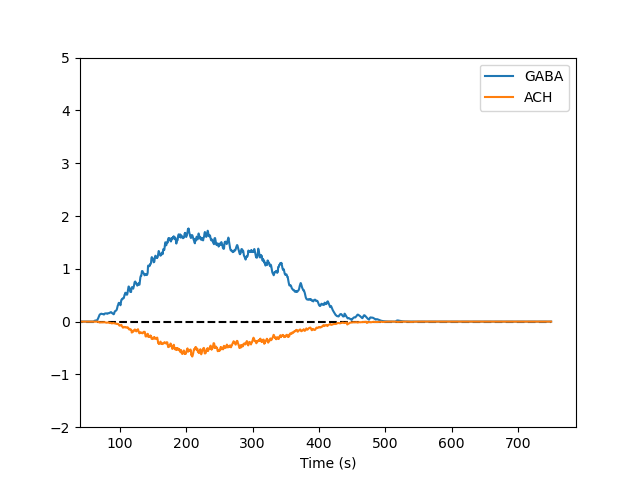

In [6]:
rho = 0.0
net = 0

ex_fig, ex_ax = plt.subplots(1)
ex_ax.plot([np.min(xaxis), np.max(xaxis)], [0, 0], c="black", linestyle="--")
for k, v in d[rho][net]["soma"].items():
    if k in ["E", "AMPA"]:
        continue
    ex_ax.plot(xaxis, v[0, 0], label=k)

ex_ax.set_xlabel("Time (s)")
ex_ax.set_xlim(40)
ex_ax.set_ylim(-2, 5)
ex_ax.legend()

In [7]:
vc_trial_avgs = {
    rho: {
        n: {trans: np.mean(rec, axis=0) for trans, rec in net["soma"].items()}
        for n, net in nets.items()
    }
    for rho, nets in d.items()      
}
    
vc_net_avgs = {
    rho: {
        trans: np.mean([net[trans] for net in nets.values()], axis=0)
        for trans in transmitters
    }
    for rho, nets in vc_trial_avgs.items()
}

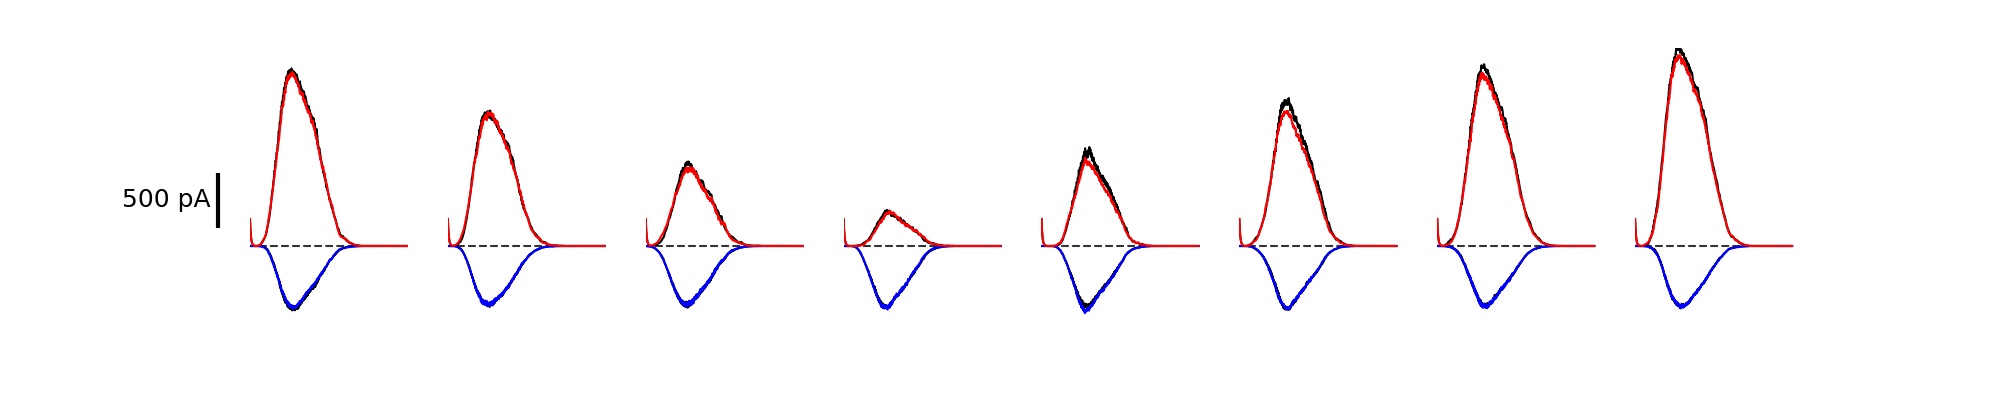

In [8]:
incl_rho0 = True
net_avg_fig, net_avg_ax = plt.subplots(
    1, len(dir_labels), sharex=True, sharey="row", figsize=(20, 4))

for i, ax in enumerate(net_avg_ax):
    ax.plot([xaxis[0], xaxis[-1]], [0., 0.], c="black", linestyle="--", alpha=0.8)
    if incl_rho0:
        ax.plot(xaxis, vc_net_avgs[0.0]["E"][i], c="black")
        ax.plot(xaxis, vc_net_avgs[0.0]["GABA"][i], c="black")
    ax.plot(xaxis, vc_net_avgs[1.0]["E"][i], c="blue")
    ax.plot(xaxis, vc_net_avgs[1.0]["GABA"][i], c="red")

clean_axes(net_avg_ax, remove_spines=["left", "right", "top", "bottom"])

add_scalebar(
    net_avg_ax[0], 
    matchx=False, 
    matchy=False, 
    # sizey=1.5, 
    # labely="1.5 nA",
    sizey=0.5, 
    labely="500 pA",
    sep=5,
    barwidth=3,
    loc="center",
    bbox_to_anchor=(170, 200),
    textprops={"fontsize": 18},
)

# net_avg_ax[-1].set_ylim(-2, 4)
net_avg_ax[-1].set_ylim(-1, 1.8)
# net_avg_ax[-1].set_ylim(-2, 6)
# net_avg_ax[-1].set_xlim(10, 300)
net_avg_ax[-1].set_xlim(10)
name = os.path.join(fig_path, "net_avg_ach_gaba%s.svg" % ("_w_rho0" if incl_rho0 else ""))
net_avg_fig.savefig(name)

In [9]:
upward_e_avgs = vc_net_avgs[1.00]["E"] * -1
time_offsets = np.array([
    find_rise_bsln(d, bsln_start=0, bsln_end=1, offset=0.03, step=1)
    for d in upward_e_avgs
]) * params["dt"]
align_offsets = np.max(time_offsets) - time_offsets

print("E field offsets (ms):", time_offsets)
print("alignment_shifts (ms):", align_offsets)

E field offsets (ms): [86.9 69.7 58.8 79.4 93.8 90.8 94.1 93.8]
alignment_shifts (ms): [ 7.2 24.4 35.3 14.7  0.3  3.3  0.   0.3]


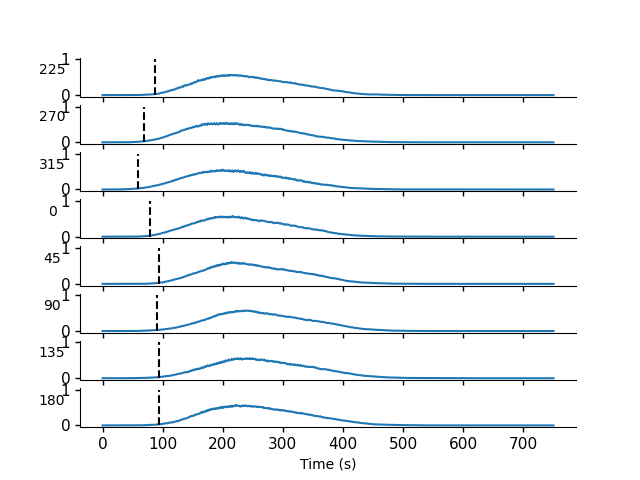

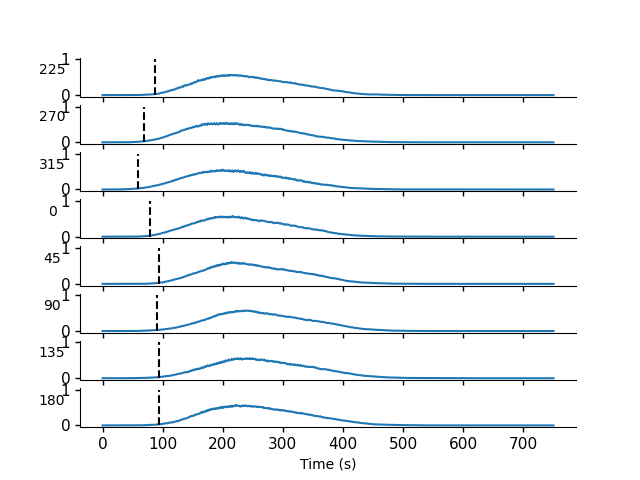

In [10]:
rf_offset_fig, rf_offset_ax = plt.subplots(8)
for ax, dr, avg, off in zip(rf_offset_ax, dir_labels, upward_e_avgs, time_offsets):
    ax.plot(xaxis, avg)
    ax.plot([off, off], [0, 1], linestyle="--", c="black")
    ax.set_ylabel(dr, rotation="horizontal", labelpad=6., position=(1, 0.3))
    
clean_axes(rf_offset_ax)
rf_offset_ax[-1].set_xlabel("Time (s)")
rf_offset_fig.show()

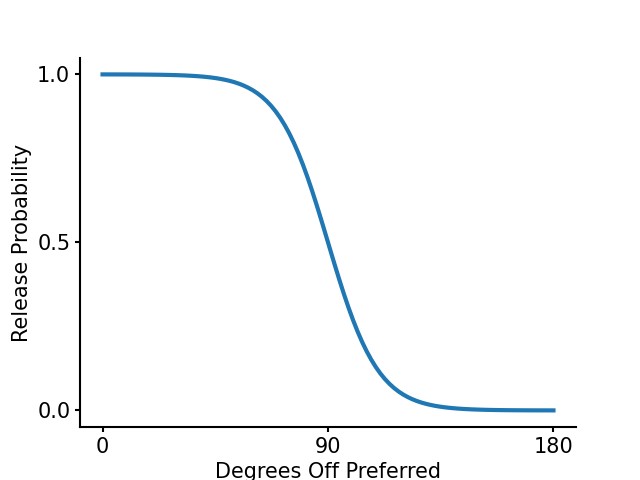

In [11]:
def sigmoid (d, n, p, offset=90, slope=0.075): 
    return p + (n - p) * (1 - 1 / (1 + np.exp((d - offset) * slope)))

# null_pr = 0.05
# pref_pr = 0.95
null_pr = 0.0
pref_pr = 1.0

dir_range = np.linspace(0, 180, 100) 
prob_p1 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, offset=90, slope=0.1))
prob_p075 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr))
prob_p05 = np.squeeze(sigmoid(dir_range, null_pr, pref_pr, slope=null_pr))

sigmoid_fig, sigmoid_ax = plt.subplots(1)
sigmoid_ax.plot(dir_range, prob_p1, linewidth=3, label="slope 0.1")
# sigmoid_ax.plot(dir_range, prob_p075, linewidth=3, label="slope 0.075")
# sigmoid_ax.plot(dir_range, prob_p05, linewidth=3, label="slope 0.05")
sigmoid_ax.set_ylabel("Release Probability", fontsize=15)
sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
sigmoid_ax.set_yticks([0, 0.5, 1])
sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
# sigmoid_fig.legend()
sigmoid_fig.savefig(os.path.join(fig_path, "prob_sigmoid.svg"), bbox_inches="tight")

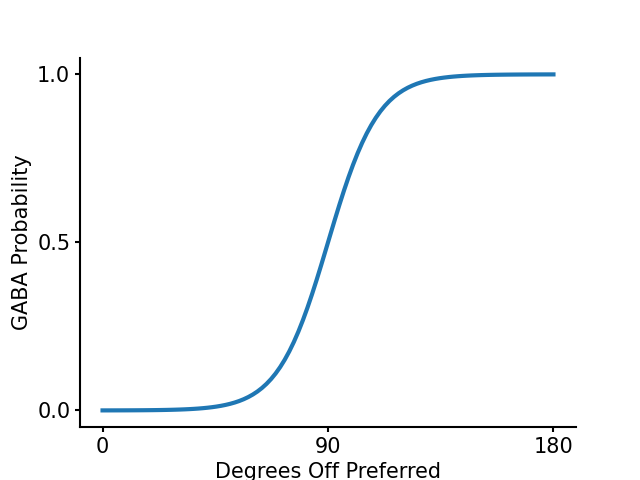

In [12]:
gaba_sigmoid_fig, gaba_sigmoid_ax = plt.subplots(1)
gaba_sigmoid_ax.plot(180 - dir_range, prob_p1, linewidth=3)
gaba_sigmoid_ax.set_ylabel("GABA Probability", fontsize=15)
gaba_sigmoid_ax.set_xlabel("Degrees Off Preferred", fontsize=15)
clean_axes(gaba_sigmoid_ax, ticksize=15)
gaba_sigmoid_ax.set_yticks([0, 0.5, 1])
gaba_sigmoid_ax.set_xticks([0, 90, 180])
clean_axes(gaba_sigmoid_ax, ticksize=15, spine_width=1.5, tick_width=1.5)
gaba_sigmoid_fig.savefig(os.path.join(fig_path, "gaba_sigmoid.svg"), bbox_inches="tight")

In [15]:
residuals = {
    rho: {
        net: {
            k: d[rho][net]["soma"][k] - vc_trial_avgs[rho][net][k]
            for k in ["ACH", "GABA"] 
        }
        for net in idxs
    }
    for rho in vc_trial_avgs.keys()
}

In [62]:
def norm_residuals(corr_mode):
    return {
        rho: {
            i: map_axis(
                lambda s: np.squeeze(norm_xcorr(s[0], s[1], mode=corr_mode)) * -1,
                np.stack([net["ACH"], net["GABA"]], axis=-2),
                axis=-2
            )
            for i, net in nets.items()
        }
        for rho, nets in residuals.items()
   } 

residual_corr_valid = norm_residuals("valid")
residual_corr_full = norm_residuals("full")

In [68]:
residual_corr_valid_trial_avg = {
    rho: {i: np.mean(net, axis=0) for i, net in nets.items()}
    for rho, nets in residual_corr_valid.items()
}
residual_corr_full_trial_avg = {
    rho: {i: np.mean(net, axis=0) for i, net in nets.items()}
    for rho, nets in residual_corr_full.items()
}
residual_corr_full_peak_trial_avg = {
    rho: {i: np.max(net, axis=-1) for i, net in nets.items()}
    for rho, nets in residual_corr_full_trial_avg.items()
}

residual_corr_valid_net_avg = {
    rho: np.mean(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_valid_trial_avg.items()
}
residual_corr_full_net_avg = {
    rho: np.mean(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_full_trial_avg.items()
}
residual_corr_full_peak_net_avg = {
    rho: np.mean(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_full_peak_trial_avg.items()
}
residual_corr_valid_net_std = {
    rho: np.std(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_valid_trial_avg.items()
}
residual_corr_full_net_std = {
    rho: np.std(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_full_trial_avg.items()
}
residual_corr_full_peak_net_std = {
    rho: np.std(np.stack([net for net in nets.values()], axis=0), axis=0)
    for rho, nets in residual_corr_full_peak_trial_avg.items()
}

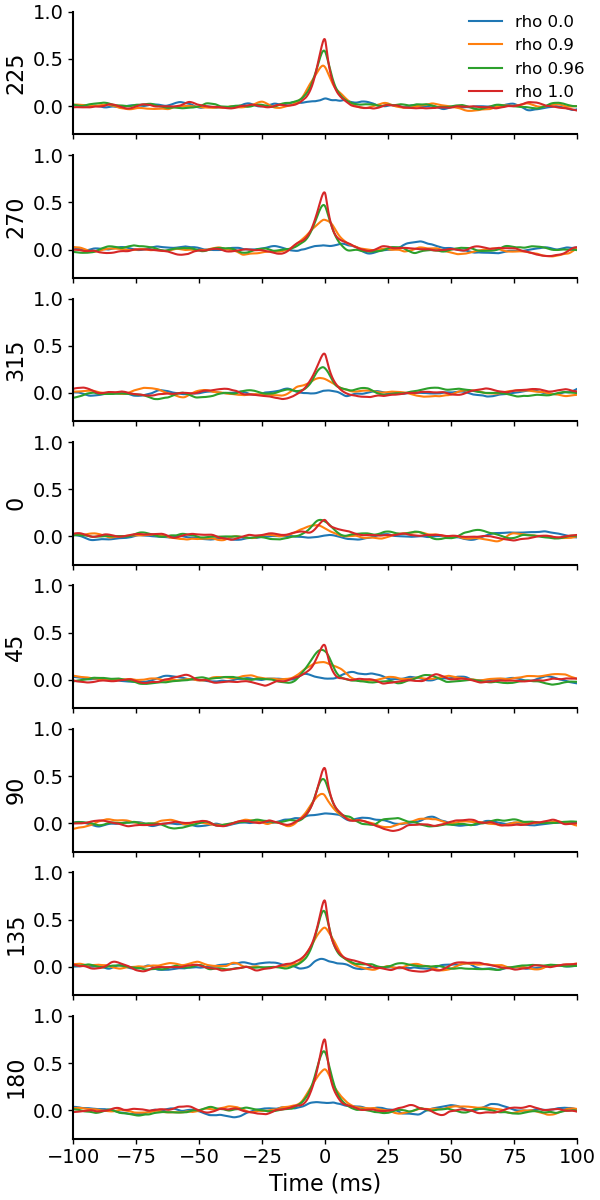

In [77]:
show_rhos = [0.0, 0.9, 0.96, 1.0]
full_xaxis = np.concatenate([np.flip(xaxis[1:] * -1), xaxis])
dir_residual_corr_fig, dir_residual_corr_ax = plt.subplots(len(dir_labels), sharex=True, sharey=True, figsize=(6, 12))
for i in range(len(dir_labels)):
    for rho in show_rhos:
        lbl = ("rho " + str(rho)) if not i else None
        dir_residual_corr_ax[i].plot(full_xaxis, residual_corr_full_net_avg[rho][i], label=lbl)
    dir_residual_corr_ax[i].set_ylabel(dir_labels[i], fontsize=16)

dir_residual_corr_ax[-1].set_xlim(-100, 100)
dir_residual_corr_ax[-1].set_ylim(-0.3, 1)
dir_residual_corr_ax[-1].set_xlabel("Time (ms)", fontsize=16)
dir_residual_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(dir_residual_corr_ax, ticksize=14, spine_width=1.5)
dir_residual_corr_fig.set_layout_engine("compressed")

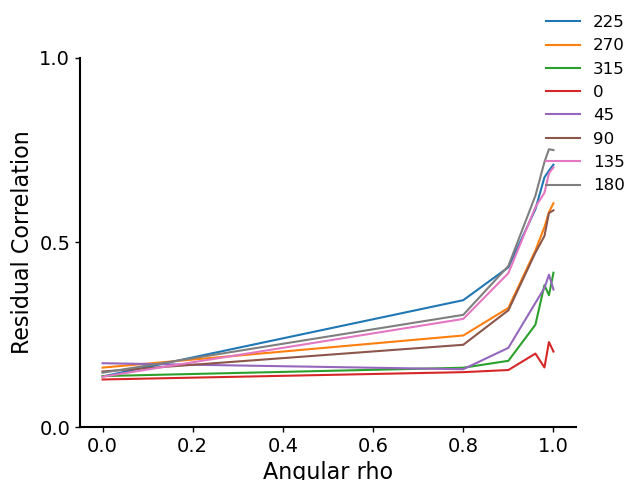

In [76]:
rho_vs_corr_fig, rho_vs_corr_ax = plt.subplots(1)

for i in range(len(dir_labels)):
    corrs = [residual_corr_full_peak_net_avg[r][i] for r in rhos] 
    rho_vs_corr_ax.plot(rhos, corrs, label=dir_labels[i])
    
rho_vs_corr_ax.set_ylim(0, 1)
rho_vs_corr_ax.set_yticks([0, 0.5, 1.])
rho_vs_corr_ax.set_xlabel("Angular rho", fontsize=16)
rho_vs_corr_ax.set_ylabel("Residual Correlation", fontsize=16)
rho_vs_corr_fig.legend(frameon=False, fontsize=12)
clean_axes(rho_vs_corr_ax, ticksize=14, spine_width=1.5)